# Tutorial 1. Controlling a basic experiment using MeasurementControl

```{seealso}
The complete source code of this tutorial can be found in

{nb-download}`Tutorial 1. Controlling a basic experiment using MeasurementControl.ipynb`
```

## Introduction

Following this Tutorial requires familiarity with the **core concepts** of Quantify, we **highly recommended** to consult the (short) {ref}`User guide` before proceeding (see Quantify documentation). If you have some difficulties following the tutorial it might be worth reviewing the {ref}`User guide` !

This tutorial covers the basic usage of Quantify focusing on running basic experiments using {class}`.MeasurementControl`.
The {class}`.MeasurementControl` is the main {class}`~qcodes.instrument.Instrument` in charge of running any experiment.

It takes care of saving the data in a standardized format as well as live plotting of the data during the experiment.
Quantify makes a distinction between {ref}`Iterative<Control Mode>` measurements and {ref}`Batched<Control Mode>` measurements.

In an {ref}`Iterative<Control Mode>` measurement, the {class}`.MeasurementControl` processes each setpoint fully before advancing to the next.

In a {ref}`Batched<Control Mode>` measurement, the {class}`.MeasurementControl` processes setpoints in batches, for example triggering 10 samples and then reading those 10 outputs.
This is useful in resource constrained or overhead heavy situations.

Both measurement policies can be 1D, 2D or higher dimensional. Quantify also supports adaptive measurements in which the datapoints are determined during the measurement loop, which are explored in subsequent tutorials.

This tutorial is structured as follows.
In the first section we use a 1D Iterative loop to explain the flow of a basic experiment.
We start by setting up a noisy cosine model to serve as our mock setup and then use the meas_ctrl to measure this.
We then execute an analysis on the data from this experiment.

"先自製含雜訊的cos訊號當model，之後去測量這個訊號、分析並儲存資訊"

### Import modules and instantiate the MeasurementControl

In [1]:
import numpy as np

import quantify_core.visualization.pyqt_plotmon as pqm
from quantify_core.analysis import base_analysis as ba
from quantify_core.analysis import cosine_analysis as ca
from quantify_core.data.handling import (
    default_datadir,
    set_datadir,
)
from quantify_core.measurement import MeasurementControl
from quantify_core.utilities.examples_support import mk_cosine_instrument
from quantify_core.utilities.experiment_helpers import create_plotmon_from_historical

from quantify_core.utilities.inspect_utils import display_source_code
from quantify_core.visualization.instrument_monitor import InstrumentMonitor


Before instantiating any instruments or starting a measurement we change the
directory in which the experiments are saved using the
{meth}`~quantify_core.data.handling.set_datadir`
\[{meth}`~quantify_core.data.handling.get_datadir`\] functions.

----------------------------------------------------------------------------------------

⚠️ **Warning!**

We recommend always setting the directory at the start of the python kernel and stick
to a single common data directory for all notebooks/experiments within your
measurement setup/PC.

The cell below sets a default data directory (`~/quantify-data` on Linux/macOS or
`$env:USERPROFILE\\quantify-data` on Windows) for tutorial purposes. Change it to your
desired data directory. The utilities to find/search/extract data only work if
all the experiment containers are located within the same directory.

----------------------------------------------------------------------------------------

In [2]:
set_datadir('D:\HW\量子元件實驗室\Qblox\Qblox_datadir')  # change me!


In [3]:
meas_ctrl = MeasurementControl("meas_ctrl")

# Create the live plotting instrument which handles the graphical interface
# Two windows will be created, the main will feature 1D plots and any 2D plots will go to the secondary
plotmon = pqm.PlotMonitor_pyqt("plotmon")
# Connect the live plotting monitor to the measurement control
meas_ctrl.instr_plotmon(plotmon.name)

# The instrument monitor will give an overview of all parameters of all instruments
insmon = InstrumentMonitor("InstrumentMonitor")


### Define a simple model  製作簡單的含雜訊cos訊號當作我們要接收到的訊號

We start by defining a simple model to mock our experiment setup (i.e. emulate physical setup for demonstration purposes).
We will be generating a cosine with some normally distributed noise added on top of it.

In [ ]:
# We create an instrument to contain all the parameters of our model to ensure
# we have proper data logging.
display_source_code(mk_cosine_instrument)


In [4]:
pars = mk_cosine_instrument()


Many experiments involving physical instruments are much slower than the time it takes to simulate our `cosine_model`, that is why we added a `sleep()` controlled by the `acq_delay`.

This allows us to exemplify (later in the tutorial) some of the features of the meas_ctrl that would be imperceptible otherwise.

In [5]:
# by setting this to a non-zero value we can see the live plotting in action for a slower experiment
pars.acq_delay(0.0)


## A 1D Iterative loop

### Running the 1D experiment

The complete experiment is defined in just 4 lines of code. We specify what parameter we want to set, time `t` in this case, what points to measure at, and what parameter to measure.
We then tell the {ref}`MeasurementControl<Measurement Control>` `meas_ctrl` to run which will return an {class}`~xarray.Dataset` object.

We use the {class}`.Settable` and {class}`.Gettable` helper classes to ensure our parameters contain the correct attributes.

In [6]:
meas_ctrl.settables(
    pars.t
)  # as a QCoDeS parameter, 't' obeys the JSON schema for a valid Settable and can be passed to the meas_ctrl directly.
meas_ctrl.setpoints(np.linspace(0, 2, 50))
meas_ctrl.gettables(
    pars.sig
)  # as a QCoDeS parameter, 'sig' obeys the JSON schema for a valid Gettable and can be passed to the meas_ctrl directly.
dataset = meas_ctrl.run("Cosine test")


Starting iterative measurement...
100% completed | elapsed time:      0s | time left:      0s  
100% completed | elapsed time:      0s | time left:      0s  

In [8]:
plotmon.main_QtPlot


NameError: name 'plotmon' is not defined

In [11]:
# The dataset has a time-based unique identifier automatically assigned to it
# The name of the experiment is stored as well
dataset.attrs["tuid"], dataset.attrs["name"]


('20231120-150715-121-6cdb98', 'Cosine test')

The {ref}`dataset<Dataset>` is stored as an {class}`xarray.Dataset` (you can read more about xarray project at <https://docs.xarray.dev/>).

As shown below, a **Data variable** is assigned to each dimension of the settables and the gettable(s), following a format in which the settable takes the form x0, x1, etc. and the gettable(s) the form y0, y1, y2, etc.. You can click on the icons on the right to see the attributes of each variable and the values.

See {ref}`data-storage` in the {ref}`User guide` for details.

In [12]:
dataset


<xarray.Dataset>
Dimensions:  (dim_0: 50)
Coordinates:
    x0       (dim_0) float64 0.0 0.04082 0.08163 0.1224 ... 1.918 1.959 2.0
Dimensions without coordinates: dim_0
Data variables:
    y0       (dim_0) float64 0.4664 0.4704 0.4205 ... 0.4248 0.4678 0.4801
Attributes:
    tuid:                             20231120-150715-121-6cdb98
    name:                             Cosine test
    grid_2d:                          False
    grid_2d_uniformly_spaced:         False
    1d_2_settables_uniformly_spaced:  False

We can play with some live plotting options to see how the meas_ctrl behaves when changing the update interval.

In [58]:
# By default the meas_ctrl updates the datafile and live plot every 0.1 seconds (and not faster) to reduce overhead.
meas_ctrl.update_interval(
    0.1
)  # Setting it even to 0.01 creates a dramatic slowdown, try it out!



In order to avoid an experiment being bottlenecked by the `update_interval` we recommend setting it between ~0.1-1.0 s for a comfortable refresh rate and good performance.

In [59]:
meas_ctrl.settables(pars.t)
meas_ctrl.setpoints(np.linspace(0, 50, 1000))
meas_ctrl.gettables(pars.sig)
dataset = meas_ctrl.run("Many points live plot test")


Starting iterative measurement...
100% completed | elapsed time:     18s | time left:      0s  
100% completed | elapsed time:     18s | time left:      0s  

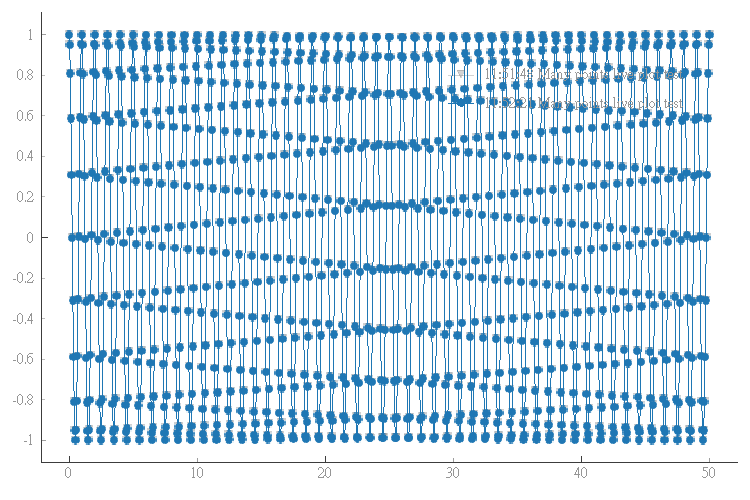

In [60]:
plotmon.main_QtPlot


In [61]:
pars.noise_level(0)  # let's disable noise from here on to get prettier figures


## Analyzing the experiment

Plotting the data and saving the plots for a simple 1D case can be achieved in a few lines using a standard analysis from the {mod}`quantify_core.analysis.base_analysis` module.
In the same module you can find several common analyses that might fit your needs.
It also provides a base data-analysis class ({class}`~quantify_core.analysis.base_analysis.BaseAnalysis`) -- a flexible framework for building custom analyses, which we explore in detail in {ref}`a dedicated tutorial <analysis-framework-tutorial>`.

The {class}`~xarray.Dataset` generated by the meas_ctrl contains all the information required to perform basic analysis of the experiment. Running an analysis can be as simple as:

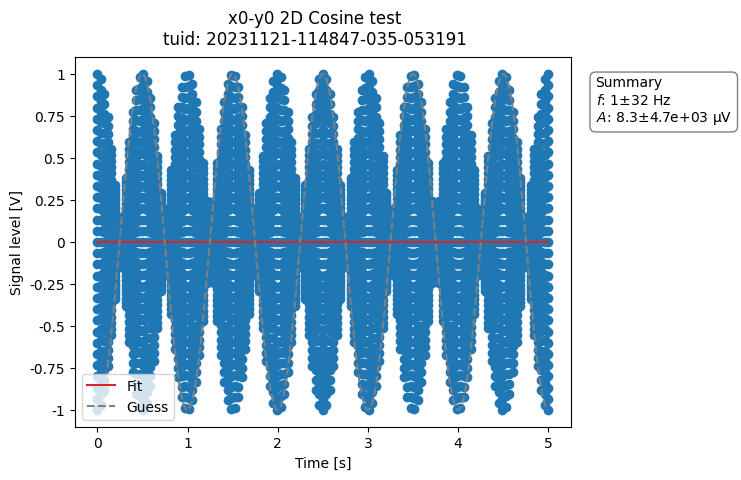

In [62]:
a_obj = ca.CosineAnalysis(label="Cosine test").run()
a_obj.display_figs_mpl()


Here the analysis loads the latest dataset on disk matching a search based on the {code}`label`. See {class}`~quantify_core.analysis.base_analysis.BaseAnalysis` for alternative dataset specification.

After loading the data, it executes the different steps of the analysis and saves the results into a directory within the experiment container.

The {ref}`data-storage` contains more details on the folder structure and
files contained in the data directory. The {mod}`quantify_core.data.handling` module provides
convenience data searching and handling utilities like {meth}`~quantify_core.data.handling.get_latest_tuid`.

For guidance on creating custom analyses, e.g., fitting a model to the data, see
{ref}`analysis-framework-tutorial` where we showcase the implementation of the analysis above.

## A 2D Iterative loop

It is often desired to measure heatmaps (2D grids) of some parameter.
This can be done by specifying two settables.
The setpoints of the grid can be specified in two ways.

### Method 1 - a quick grid

In [63]:
pars.acq_delay(0.0001)
meas_ctrl.update_interval(2.0)


In [64]:
times = np.linspace(0, 5, 129)
amps = np.linspace(-1, 1, 31)

meas_ctrl.settables([pars.t, pars.amp])
# meas_ctrl takes care of creating a meshgrid
meas_ctrl.setpoints_grid([times, amps])
meas_ctrl.gettables(pars.sig)
dataset = meas_ctrl.run("2D Cosine test")


Starting iterative measurement...
100% completed | elapsed time:     63s | time left:      0s  
100% completed | elapsed time:     63s | time left:      0s  

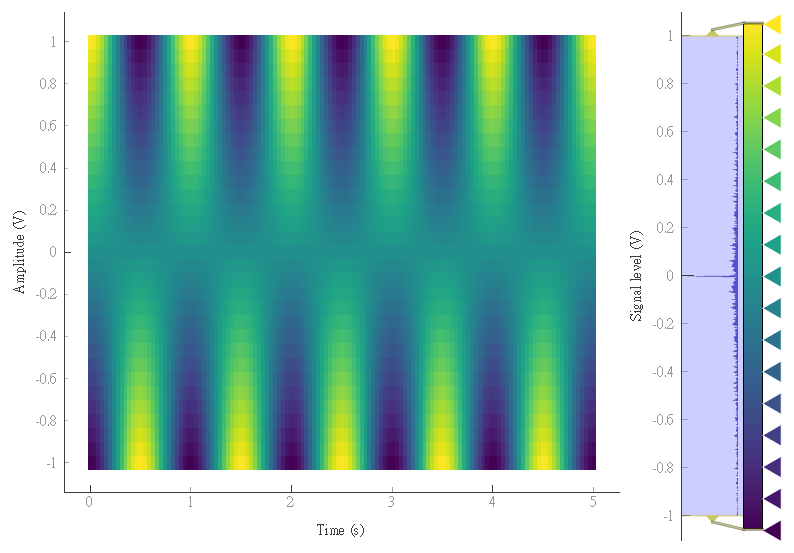

In [65]:
plotmon.secondary_QtPlot


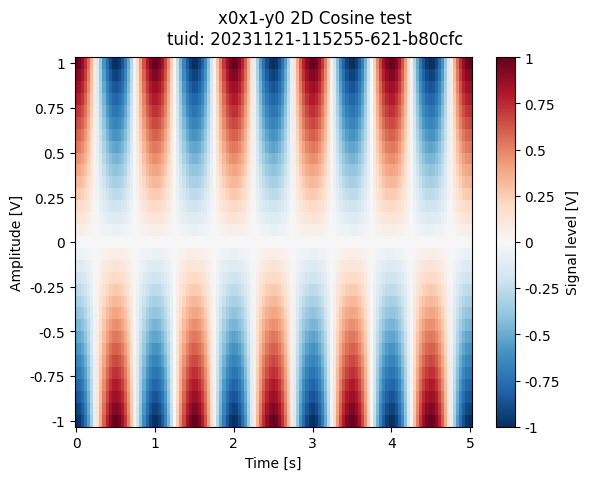

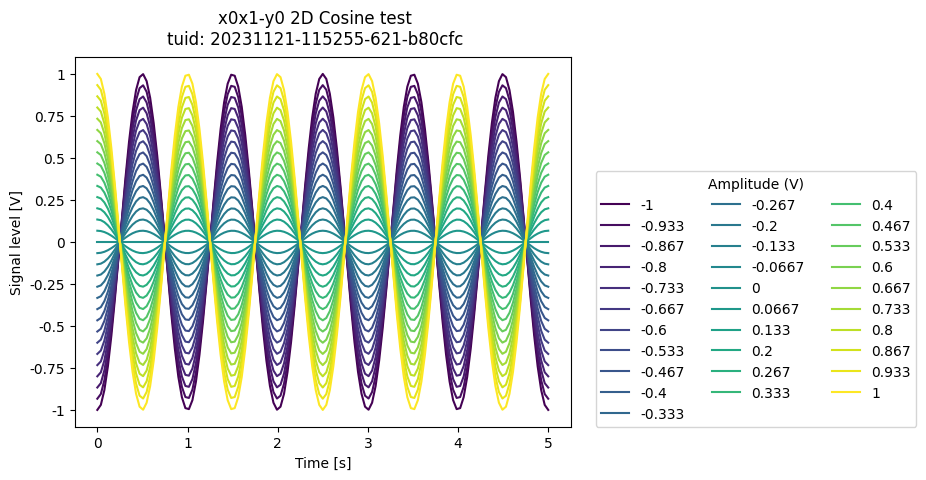

In [67]:
a_obj = ba.Basic2DAnalysis(label="2D Cosine test").run()
a_obj.display_figs_mpl()


### Method 2 - custom tuples in 2D

N.B. it is also possible to do this for higher dimensional loops

In [70]:
r = np.linspace(0, 1.2, 200)
dt = np.linspace(0, 0.5, 200)
f = 3
theta = np.cos(2 * np.pi * f * dt)


def polar_coords(r_, theta_):
    x_ = r_ * np.cos(2 * np.pi * theta_)
    y_ = r_ * np.sin(2 * np.pi * theta_)
    return x_, y_


x, y = polar_coords(r, theta)
setpoints = np.column_stack([x, y])
setpoints[:5]  # show a few points


array([[ 0.00000000e+00, -0.00000000e+00],
       [ 6.03000109e-03, -4.24843885e-05],
       [ 1.20555181e-02, -3.39642455e-04],
       [ 1.80542054e-02, -1.14460856e-03],
       [ 2.39683681e-02, -2.70570137e-03]])

In [72]:
pars.acq_delay(0.0001)
meas_ctrl.update_interval(2.0)

meas_ctrl.settables([pars.t, pars.amp])
meas_ctrl.setpoints(setpoints)
meas_ctrl.gettables(pars.sig)
dataset = meas_ctrl.run("2D radial setpoints")

Starting iterative measurement...
100% completed | elapsed time:      3s | time left:      0s  
100% completed | elapsed time:      3s | time left:      0s  

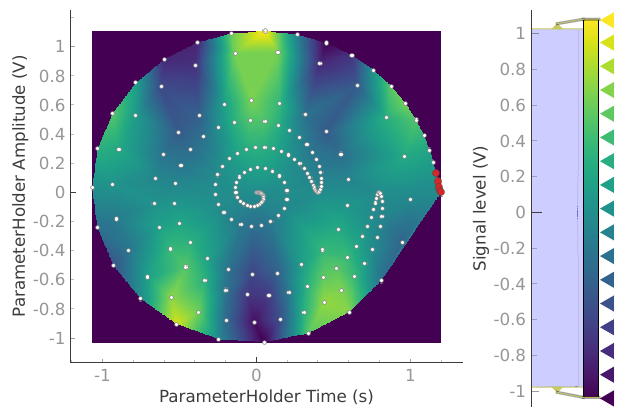

In [22]:
plotmon.secondary_QtPlot


In this case running a simple (non-interpolated) 2D analysis will not be meaningful. Nevertheless the dataset can be loaded back using the {func}`~quantify_core.utilities.experiment_helpers.create_plotmon_from_historical`

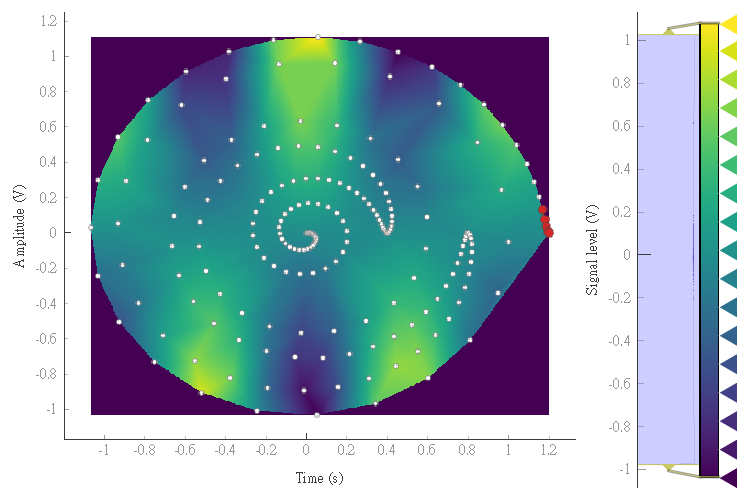

In [74]:
plotmon_loaded = create_plotmon_from_historical(label="2D radial setpoints")
plotmon_loaded.secondary_QtPlot
